In [1]:
import sys
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from time import sleep
sys.path.append('..')

from homework_3.decision_tree import DecisionTree
from random_forest import RandomForestClassifier

In [2]:
def calc_auc(model, x, y_true):
    y_pred = model.predict_proba(x)
    return roc_auc_score(y_true, y_pred[:, 1])

In [36]:
def calc_accuracy(model, x, y_true):
    y_pred = np.argmax(model.predict_proba(x), axis=1)
    accuracy = (y_true == y_pred).mean()
    return accuracy

In [4]:
def plot_roc(fpr, tpr, auc, data):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {data}, depth=3, base_models=20')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
def select_best(aucs, models, data, data_name):
    base_models, depth = max(aucs, key=aucs.get)
    print(f'{data_name}')
    print(f'Best model with {base_models} base models of max depth {depth}')
    forest = models[(base_models, depth)]
    _, x_val, _, y_val = split_data(data)
    print(f'Accuracy for the best model is {calc_accuracy(forest, x_val, y_val):.2f}')

In [41]:
def split_data(data):
    x, y = data.drop(['label'], axis=1).values, data.label.values
    x_train, x_val, y_train, y_val = tts(x, y, test_size=0.2, random_state=123)
    return x_train, x_val, y_train, y_val

In [7]:
def validate(data, n_base_models_range, depth_range):
    models = {}
    val_aucs = {}
    x_train, x_val, y_train, y_val = split_data(data)
    n_features = int(np.sqrt(x_train.shape[1]))

    base_models_bar = tqdm(range(len(n_base_models_range) * len(depth_range)), desc='Base models')

    for n_base_models in n_base_models_range:
        base_models_bar.set_description(f'{n_base_models} base models')
        depth_bar = tqdm(depth_range, desc='Depth', leave=False)
        for depth in depth_bar:
            depth_bar.set_description(f'Depth is now {depth}')
            forest = RandomForestClassifier(base_model_class=DecisionTree, n_base_models=n_base_models, n_features=n_features, 
                                            criterion_name='gini', max_depth=depth)
            forest.train(x_train, y_train)
            models[(n_base_models, depth)] = forest
            val_aucs[(n_base_models, depth)] = calc_auc(forest, x_val, y_val)
            base_models_bar.update(1)
    return models, val_aucs

In [8]:
spam = pd.read_csv('../data/spam.csv')
cancer = pd.read_csv('../data/cancer.csv')
cancer.label = cancer.label.apply(lambda x: 1 if x == 'M' else 0)

# 1

In [9]:
x, y = spam.drop(['label'], axis=1).values, spam.label.values
x_train, x_val, y_train, y_val = tts(x, y, test_size=0.2, random_state=123)

In [10]:
n_features = int(np.sqrt(x_train.shape[1]))
forest = RandomForestClassifier(base_model_class=DecisionTree, n_base_models=20, n_features=n_features,
                                criterion_name='gini', max_depth=3)
forest.train(x_train, y_train)
y_pred = forest.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_pred)

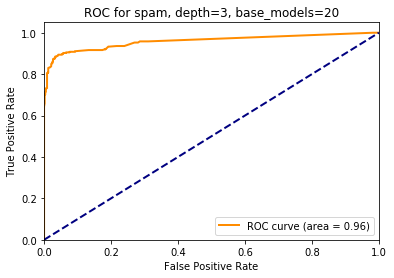

In [11]:
plot_roc(fpr, tpr, auc, 'spam')

# 2

In [12]:
n_base_models_range = [5, 10, 20, 30, 50, 100]
depth_range = [2, 3, 5, 7, 10]

In [23]:
models, val_aucs = validate(spam, n_base_models_range, depth_range)

KeyboardInterrupt: 

In [37]:
select_best(val_aucs, val_accuracies, spam, 'Spam data')

Spam data
Best model with 50 base models of max depth 10
Accuracy for the best model is 0.95


In [42]:
models, val_aucs = validate(cancer, n_base_models_range, depth_range)

TypeError: select_best() missing 1 required positional argument: 'data_name'

In [44]:
select_best(val_aucs, models, cancer, 'Cancer data')

Cancer data
Best model with 50 base models of max depth 3
Accuracy for the best model is 0.99


# 1 cancer

In [45]:
x, y = cancer.drop(['label'], axis=1).values, cancer.label.values
x_train, x_val, y_train, y_val = tts(x, y, test_size=0.2, random_state=123)

In [46]:
n_features = int(np.sqrt(x_train.shape[1]))
forest = RandomForestClassifier(base_model_class=DecisionTree, n_base_models=20, n_features=n_features,
                                criterion_name='gini', max_depth=3)
forest.train(x_train, y_train)
y_pred = forest.predict_proba(x_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_pred)

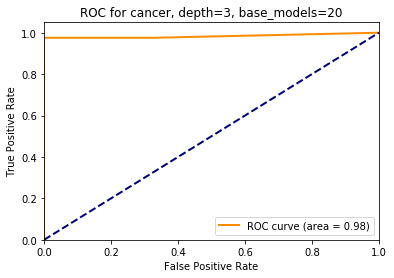

In [47]:
plot_roc(fpr, tpr, auc, 'cancer')